In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import re
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

import joblib

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)


Bad key "text.kerning_factor" on line 4 in
C:\Users\YH\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = metrics.precision_recall_curve(labels, probas_pred)
    score=metrics.auc(r,p) 
    return "pr_auc", score, True

In [3]:
def psuedo_labeling(model, X_tr, X_val, y_tr, y_val, X_te):
    
    y_prob = np.round(model.predict_proba(X_te), 2)
    y_prob = y_prob[:, 1]
    y_pred = np.where(y_prob > 0.5, 1, 0)
    y_te = y_pred

    new_X = np.concatenate((X_tr, X_te), axis=0)
    new_y = np.concatenate((y_tr, y_te), axis=0)
    
    model = model.fit(new_X, new_y)
    
    return model, new_X, new_y

# smote 알고리즘으로 데이터 불균형 해결 경우

In [4]:
"""from imblearn.over_sampling import SMOTE

def smote(X_train, y_train):
    smote = SMOTE(random_state=0)
    X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
    print('smote 적용 전 데이터 세트: ', X_train.shape, y_train.shape)
    print('smote 적용 후 데이터 세트: ', X_train_over.shape, y_train_over.shape)
    print('smote 적용 후 label 분포: \n', pd.Series(y_train_over).value_counts())
    return X_train_over, y_train_over"""

"from imblearn.over_sampling import SMOTE\n\ndef smote(X_train, y_train):\n    smote = SMOTE(random_state=0)\n    X_train_over, y_train_over = smote.fit_sample(X_train, y_train)\n    print('smote 적용 전 데이터 세트: ', X_train.shape, y_train.shape)\n    print('smote 적용 후 데이터 세트: ', X_train_over.shape, y_train_over.shape)\n    print('smote 적용 후 label 분포: \n', pd.Series(y_train_over).value_counts())\n    return X_train_over, y_train_over"

# ROC curve plotting 함수

In [5]:
from yellowbrick.classifier import ROCAUC

def plot_roc(model, i):
    fig.add_subplot(1,5,i)
    visualizer = ROCAUC(model, classes=['non_problem', 'problem'], micro=False, per_class=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_valid, y_valid)

# 기존 데이터로만 학습한 모델들의 앙상블 결과

========================= 1 =================================
[18:07:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
softvote accuracy:  0.8
softvote precision:  0.8154362416107382
softvote recall:  0.4979508196721312
softvote f1:  0.6183206106870228
softvote auc:  0.8202439071308236
========================= 2 =================================
[18:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
softvote accuracy:  0.7876666666666666
softvote precision:  0.8012820512820513
softvote 

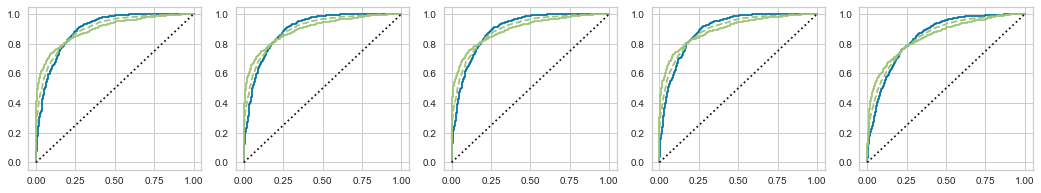

In [7]:
if __name__ == '__main__':
    label_encoder = preprocessing.LabelEncoder()
    pd.options.display.max_columns=None
    
    dataframe = pd.read_csv('train0127.csv')
    dataframe.index = np.arange(10000, 25000)
    dataframe2 = pd.read_csv('test0127.csv')
    dataframe2.index = np.arange(30000, 44999)
    dataframe2 = dataframe2.fillna(0)

    train_prob = pd.read_csv('train_problem_data.csv')
    problem = np.zeros(15000)
    problem[train_prob.user_id.unique()-10000] = 1 
    
    X = dataframe.astype(float).values
    y = problem
    X_te = dataframe2.astype(float).values
    
    kf = KFold(n_splits=5)
    i=1
    
    acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
    acc_list2, precision_list2, recall_list2, f1_list2, auc_list2 = [], [], [], [], []
    
    model_list=[]
    for train_index, valid_index in kf.split(X):
        print('=========================', i, '=================================')
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        
        
        xgboost_model = joblib.load('xgboost.model')

        rf_model = joblib.load('rf.model')

        GB_model = joblib.load('GB.model')
        
        CB_model = joblib.load('catboost.model')

            
        
        models = [
            ('XGBOOST', xgboost_model),
            #('RF', rf_model),
            ('GB', GB_model),
            ('CatBoost', CB_model)]


        # soft vote
        soft_vote  = VotingClassifier(models, voting='soft')
        model2 = soft_vote.fit(X_train, y_train)
        model_list.append(model2)
        
        y_prob2 = np.round(model2.predict_proba(X_valid), 2)
        y_prob2 = y_prob2[:, 1]
        y_pred2 = np.where(y_prob2 > 0.5, 1, 0)
        
        metric2 = metrics.confusion_matrix(y_valid, y_pred2)
        acc2 = metrics.accuracy_score(y_valid, y_pred2)
        precision2 = metrics.precision_score(y_valid, y_pred2)
        recall2 = metrics.recall_score(y_valid, y_pred2)
        f12 = metrics.f1_score(y_valid, y_pred2)
        auc2 = metrics.roc_auc_score(y_valid, y_prob2)
        
        
        
        # softvote
        print('softvote accuracy: ', acc2)
        print('softvote precision: ', precision2)
        print('softvote recall: ', recall2)
        print('softvote f1: ', f12)
        print('softvote auc: ', auc2)
        
        acc_list2.append(acc2)
        precision_list2.append(precision2)
        recall_list2.append(recall2)
        f1_list2.append(f12)
        auc_list2.append(auc2)
        
        i+=1
        
    print('----------------------- final result ------------------------------')
    print('softvote average of accuracy', np.mean(acc_list2))
    print('softvote average of precision', np.mean(precision_list2))
    print('softvote average of recall', np.mean(recall_list2))
    print('softvote average of f1', np.mean(f1_list2))
    print('softvote average of AUC', np.mean(auc_list2))
    
    fig = plt.figure(figsize=(18, 3))
    for i in range(len(model_list)):
        plot_roc(model_list[i], i+1)
    plt.show()

In [9]:
pred_y_list = []
for model in model_list:
    pred_y = model.predict_proba(X_te)
    pred_y = pred_y[:,1]
    pred_y_list.append(pred_y.reshape(-1,1))
    
mean_pred = np.mean(pred_y_list, axis=0)
print(mean_pred)
print(len(mean_pred))

submission = pd.read_csv('./submission/sample_submission.csv')
submission['problem'] = mean_pred.reshape(-1)
submission.to_csv('ensemble_xgboost_rf_GB_CB_0129.csv', index=False)

[[0.96389344]
 [0.27894373]
 [0.41097508]
 ...
 [0.5952737 ]
 [0.9006437 ]
 [0.28153615]]
14999


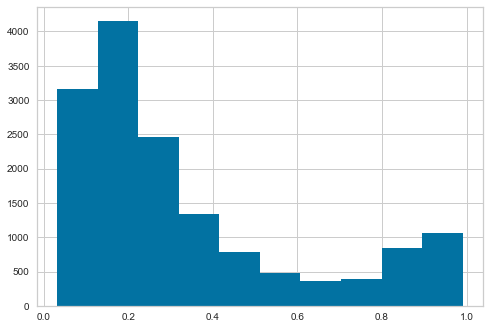

0_class number:  11812
1_class number:  3187


In [10]:
plt.hist(submission.problem)
plt.grid(True)
plt.show()

tot_1 = 0
tot_0 = 0
for i in submission.problem:
    if i > 0.5:
        tot_1 += 1
    else:
        tot_0 += 1
        
print('0_class number: ', tot_0)
print('1_class number: ', tot_1)

In [11]:
pred_y = model2.predict_proba(X_te)
pred_y = pred_y[:,1]
    
mean_pred = pred_y
print(mean_pred)
print(len(mean_pred))

submission = pd.read_csv('./submission/sample_submission.csv')
submission['problem'] = mean_pred.reshape(-1)
submission.to_csv('kfx_ensemble_xgboost_rf_GB_CB_0129.csv', index=False)

[0.95524404 0.3171899  0.44133784 ... 0.60546772 0.89153598 0.30401008]
14999


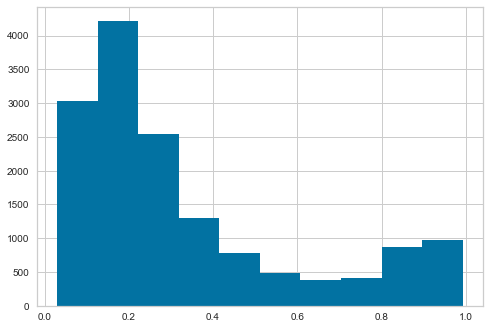

0_class number:  11809
1_class number:  3190


In [12]:
plt.hist(submission.problem)
plt.grid(True)
plt.show()

tot_1 = 0
tot_0 = 0
for i in submission.problem:
    if i > 0.5:
        tot_1 += 1
    else:
        tot_0 += 1

print('0_class number: ', tot_0)
print('1_class number: ', tot_1)

# psuedo labeling 데이터 학습시킨 모델의 앙상블 결과

========================= 1 =================================
[18:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
softvote accuracy:  0.799
softvote precision:  0.8092868988391376
softvote recall:  0.5
softvote f1:  0.6181127295756809
softvote auc:  0.8208422596870343
========================= 2 =================================
[18:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061:

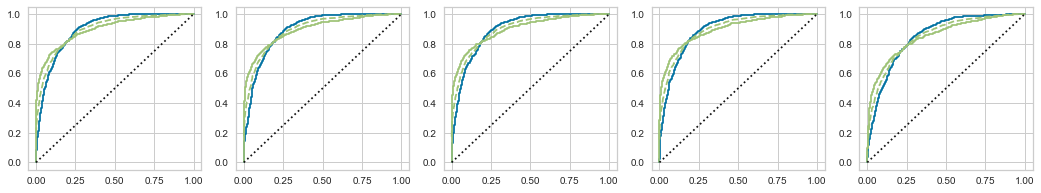

In [13]:
if __name__ == '__main__':
    label_encoder = preprocessing.LabelEncoder()
    pd.options.display.max_columns=None
    
    dataframe = pd.read_csv('train0127.csv')
    dataframe.index = np.arange(10000, 25000)

    dataframe2 = pd.read_csv('test0127.csv')
    dataframe2.index = np.arange(30000, 44999)
    dataframe2 = dataframe2.fillna(0)
    
    train_prob = pd.read_csv('train_problem_data.csv')
    problem = np.zeros(15000)
    problem[train_prob.user_id.unique()-10000] = 1 
    
    X = dataframe.astype(float).values
    y = problem
    # X, y = smote(X, y)
    X_te = dataframe2
    
    kf = KFold(n_splits=5)
    i=1
    

    acc_list2, precision_list2, recall_list2, auc_list2 = [], [], [], []
    
    model_list=[]
    for train_index, valid_index in kf.split(X):
        print('=========================', i, '=================================')
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        
        
        xgboost_model = joblib.load('xgboost.model')
        xgboost_psuedo, new_X, new_y = psuedo_labeling(xgboost_model, X_train, X_valid, y_train, y_valid, X_te)
        rf_model = joblib.load('rf.model')
        rf_psuedo,_,_ = psuedo_labeling(rf_model, X_train, X_valid, y_train, y_valid, X_te)
        GB_model = joblib.load('GB.model')
        GB_psuedo,_,_ = psuedo_labeling(GB_model, X_train, X_valid, y_train, y_valid, X_te)
        CB_model = joblib.load('catboost.model')
        CB_psuedo,_,_ = psuedo_labeling(CB_model, X_train, X_valid, y_train, y_valid, X_te)    
        
        models = [
            ('XGBOOST', xgboost_psuedo),
            #('RF', rf_model),
            ('GB', GB_psuedo),
            ('CatBoost', CB_psuedo)]


        # soft vote
        soft_vote  = VotingClassifier(models, voting='soft')
        model2 = soft_vote.fit(X_train, y_train)
        model_list.append(model2)
        
        y_prob2 = np.round(model2.predict_proba(X_valid), 2)
        y_prob2 = y_prob2[:, 1]
        y_pred2 = np.where(y_prob2 > 0.5, 1, 0)
        
        metric2 = metrics.confusion_matrix(y_valid, y_pred2)
        acc2 = metrics.accuracy_score(y_valid, y_pred2)
        precision2 = metrics.precision_score(y_valid, y_pred2)
        recall2 = metrics.recall_score(y_valid, y_pred2)
        f12 = metrics.f1_score(y_valid, y_pred2)
        auc2 = metrics.roc_auc_score(y_valid, y_prob2)
        
        
        
        # softvote
        print('softvote accuracy: ', acc2)
        print('softvote precision: ', precision2)
        print('softvote recall: ', recall2)
        print('softvote f1: ', f12)
        print('softvote auc: ', auc2)
        
        acc_list2.append(acc2)
        precision_list2.append(precision2)
        recall_list2.append(recall2)
        f1_list2.append(f12)
        auc_list2.append(auc2)
        
        i+=1
        
    print('----------------------- final result ------------------------------')
    print('softvote average of accuracy', np.mean(acc_list2))
    print('softvote average of precision', np.mean(precision_list2))
    print('softvote average of recall', np.mean(recall_list2))
    print('softvote average of f1', np.mean(f1_list2))
    print('softvote average of AUC', np.mean(auc_list2))
    
    fig = plt.figure(figsize=(18, 3))
    for i in range(len(model_list)):
        plot_roc(model_list[i], i+1)
    plt.show()

In [14]:
pred_y_list = []
for model in model_list:
    pred_y = model.predict_proba(X_te)
    pred_y = pred_y[:,1]
    pred_y_list.append(pred_y.reshape(-1,1))
    
mean_pred = np.mean(pred_y_list, axis=0)
print(mean_pred)
print(len(mean_pred))

submission = pd.read_csv('./submission/sample_submission.csv')
submission['problem'] = mean_pred.reshape(-1)
submission.to_csv('ensemble_xgboost_rf_GB_CB_(psuedo)_0129.csv', index=False)

[[0.95935906]
 [0.27789566]
 [0.39990651]
 ...
 [0.60230931]
 [0.89831568]
 [0.2601204 ]]
14999


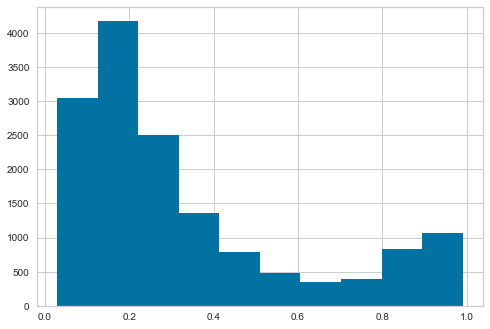

0_class number:  11810
1_class number:  3189


In [15]:
plt.hist(submission.problem)
plt.grid(True)
plt.show()

tot_1 = 0
tot_0 = 0
for i in submission.problem:
    if i > 0.5:
        tot_1 += 1
    else:
        tot_0 += 1

print('0_class number: ', tot_0)
print('1_class number: ', tot_1)

In [16]:
pred_y = model2.predict_proba(X_te)
pred_y = pred_y[:,1]
    
mean_pred = pred_y
print(mean_pred)
print(len(mean_pred))

submission = pd.read_csv('./submission/sample_submission.csv')
submission['problem'] = mean_pred.reshape(-1)
submission.to_csv('kfx_ensemble_xgboost_rf_GB_CB_(psuedo)_0129.csv', index=False)

[0.96868391 0.34064729 0.38796622 ... 0.56083969 0.89191471 0.28597735]
14999


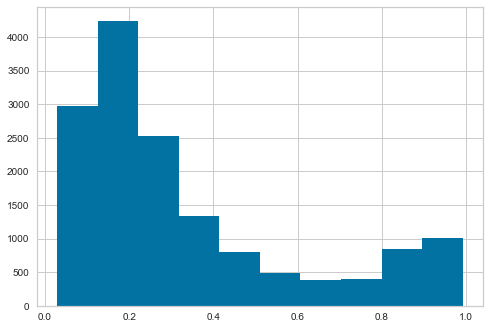

0_class number:  11802
1_class number:  3197


In [17]:
plt.hist(submission.problem)
plt.grid(True)
plt.show()

tot_1 = 0
tot_0 = 0
for i in submission.problem:
    if i > 0.5:
        tot_1 += 1
    else:
        tot_0 += 1

print('0_class number: ', tot_0)
print('1_class number: ', tot_1)